# Inference and visualization for DiffAssemble


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile

In [34]:
from src.model.full_models import *
from src.full_dataset import *
from src.gnn_diffusion import GNN_Diffusion

### 0.- Define paths and steps

In [35]:
dataset_path = os.path.join(os.getcwd(), "data/CelebA-HQ")
print(dataset_path)

steps = 2

/home/mlmcri/Documentos/Courses/2025_2026_AI_course/deep-learning-puzzle-project/data/CelebA-HQ


### 1.- Load test dataset


Test dataset length: 5999
Sample image: 


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

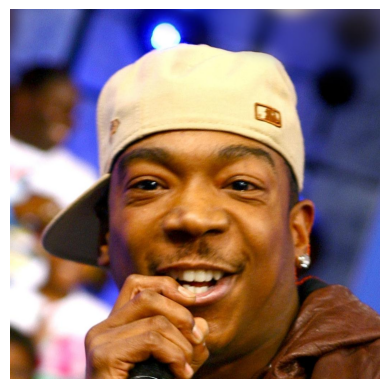

In [ ]:
# Load base dataset
test_dataset_base = CelebA_HQ(dataset_path, train=False)
print(f"Test dataset length: {len(test_dataset_base)}")
print(f"Sample image: ")
plt.imshow(test_dataset_base[0])
plt.axis("off")

In [ ]:
# Load puzzle dataset and sample an element
test_puzzle_dt = Puzzle_Dataset_ROT(
                        dataset=test_dataset_base,
                        dataset_get_fn=lambda x: x,
                        patch_per_dim=[(6,6)], 
                        augment=False, 
                        degree=-1, 
                        unique_graph=None, 
                        all_equivariant=False, 
                        random_dropout=False)

elem = test_puzzle_dt[0]

print(elem)
print(f"X: {elem.x}") # This contains all the node features: x, y, rot1, rot2
print(f"EDGE_INDEX: {elem.edge_index}")
print(f"INDEXES: {elem.indexes}")
print(f"ROT: {elem.rot}")
print(f"ROT_INDEX: {elem.rot_index}")
print(f"IND_NAME: {elem.ind_name}")

Data(x=[36, 4], edge_index=[2, 1296], indexes=[36], rot=[36, 2], rot_index=[36], patches=[36, 3, 32, 32], ind_name=[1], patches_dim=[1, 2])
X: tensor([[-1.0000, -1.0000,  0.0000,  1.0000],
        [-0.6000, -1.0000,  0.0000,  1.0000],
        [-0.2000, -1.0000, -1.0000,  0.0000],
        [ 0.2000, -1.0000, -1.0000,  0.0000],
        [ 0.6000, -1.0000,  1.0000,  0.0000],
        [ 1.0000, -1.0000,  0.0000, -1.0000],
        [-1.0000, -0.6000, -1.0000,  0.0000],
        [-0.6000, -0.6000,  1.0000,  0.0000],
        [-0.2000, -0.6000,  1.0000,  0.0000],
        [ 0.2000, -0.6000, -1.0000,  0.0000],
        [ 0.6000, -0.6000,  1.0000,  0.0000],
        [ 1.0000, -0.6000,  1.0000,  0.0000],
        [-1.0000, -0.2000, -1.0000,  0.0000],
        [-0.6000, -0.2000, -1.0000,  0.0000],
        [-0.2000, -0.2000,  0.0000,  1.0000],
        [ 0.2000, -0.2000, -1.0000,  0.0000],
        [ 0.6000, -0.2000,  0.0000, -1.0000],
        [ 1.0000, -0.2000,  0.0000,  1.0000],
        [-1.0000,  0.2000,  0

### Load model with the checkpoint from training

In [ ]:
#Load model
model = Eff_GAT(steps=2,
                input_channels=4,
                output_channels=4,
                n_layers=4,
                model="resnet18equiv",
                architecture="transformer")

# Load model with the checkpoint and set to evaluation mode
checkpoint = torch.load("checkpoints/eff_gat_epoch_30_steps_2_batchsize_10_puzzdim_6_6.pt",
                        weights_only=False,
                        map_location=torch.device("cpu"))
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print("Model parameters after loading checkpoint:")
for name, param in model.named_parameters():
    print(name, param)


Model parameters after loading checkpoint:
visual_backbone.conv1.weight Parameter containing:
tensor([[[[[ 1.0610e-01,  1.4785e-01, -1.0841e-01],
           [ 5.0436e-03,  2.2646e-01, -1.3420e-01],
           [ 1.7865e-01,  1.0226e-03,  2.2743e-01]]],


         [[[-3.9521e-02, -2.6801e-02, -1.1995e-01],
           [ 1.7987e-01, -7.7370e-02, -3.8923e-02],
           [ 1.8158e-01, -8.9451e-02,  1.5592e-02]]],


         [[[ 2.0602e-01, -1.0503e-01,  1.7426e-01],
           [-8.6580e-02,  5.8716e-02,  3.2934e-02],
           [ 2.4019e-02,  1.8219e-01,  2.7434e-02]]]],



        [[[[ 1.4353e-01, -6.7664e-03,  2.2284e-01],
           [ 1.1139e-02,  1.4088e-01, -5.3116e-02],
           [-6.7335e-02, -3.6342e-02, -1.2280e-01]]],


         [[[ 1.3207e-01, -4.4598e-02,  1.4606e-01],
           [-1.5088e-01, -2.2489e-02,  2.8454e-02],
           [ 1.2745e-02, -8.2694e-02, -7.0226e-02]]],


         [[[ 1.0303e-01,  1.7686e-01, -1.1337e-01],
           [ 5.4598e-02, -1.4329e-01,  2.1649e-01],


### Run inference with a single sample

In [ ]:
# Add test step to the GNN Diffusion class
# Modify to return noise and predicted noise AND work with batches of size = 1 in a controlled manner
class GNN_Diffusion_Inference(GNN_Diffusion):
    
    def inference_step(self, sample, model, criterion):
        sample = sample.to(self.device)

        if not sample.batch:
            sample.batch = torch.zeros(sample.x.size(0), dtype=torch.long, device=self.device)
        
        print(sample.batch)

        num_graphs = int(sample.batch.max().item()) + 1
        t_graph = torch.randint(0, self.steps, (num_graphs,), device=self.device).long()
        t = torch.gather(t_graph, 0, sample.batch)

        x_start = sample.x
        noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)

        patch_feats = model.visual_features(sample.patches)
        prediction, _ = model.forward_with_feats(
            x_noisy, t, sample.patches, sample.edge_index, patch_feats, sample.batch
        )
        return criterion(noise, prediction)


In [75]:
# Dataloader
test_loader = torch.utils.data.DataLoader(test_puzzle_dt, batch_size=1, shuffle=False)
sample = test_puzzle_dt[0]
print(f"X: {sample.x}") # This contains all the node features: x, y, rot1, rot2
print(f"EDGE_INDEX: {sample.edge_index}")
print(f"INDEXES: {sample.indexes}")
print(f"ROT: {sample.rot}")
print(f"ROT_INDEX: {sample.rot_index}")
print(f"IND_NAME: {sample.ind_name}")


X: tensor([[-1.0000, -1.0000,  0.0000,  1.0000],
        [-0.6000, -1.0000,  0.0000,  1.0000],
        [-0.2000, -1.0000,  0.0000, -1.0000],
        [ 0.2000, -1.0000, -1.0000,  0.0000],
        [ 0.6000, -1.0000,  0.0000, -1.0000],
        [ 1.0000, -1.0000,  0.0000,  1.0000],
        [-1.0000, -0.6000,  0.0000, -1.0000],
        [-0.6000, -0.6000, -1.0000,  0.0000],
        [-0.2000, -0.6000,  1.0000,  0.0000],
        [ 0.2000, -0.6000,  0.0000, -1.0000],
        [ 0.6000, -0.6000, -1.0000,  0.0000],
        [ 1.0000, -0.6000, -1.0000,  0.0000],
        [-1.0000, -0.2000, -1.0000,  0.0000],
        [-0.6000, -0.2000, -1.0000,  0.0000],
        [-0.2000, -0.2000, -1.0000,  0.0000],
        [ 0.2000, -0.2000, -1.0000,  0.0000],
        [ 0.6000, -0.2000,  0.0000, -1.0000],
        [ 1.0000, -0.2000,  0.0000, -1.0000],
        [-1.0000,  0.2000,  0.0000,  1.0000],
        [-0.6000,  0.2000, -1.0000,  0.0000],
        [-0.2000,  0.2000,  0.0000, -1.0000],
        [ 0.2000,  0.2000, -1.0

In [76]:
# Load criterion, inference GNN Diffusion class, and run inference step
criterion = torch.nn.functional.smooth_l1_loss
gnn_diffusion = GNN_Diffusion_Inference(steps=steps)

with torch.no_grad():
    #This only returns loss, we need to modify to return noise and predicted noise for visualization
    loss = gnn_diffusion.inference_step(sample, model, criterion)


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [77]:
loss

tensor(0.1890)